In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Setup Mediapipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

### Extract Landmark Function

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

## Setup Folders Dataset and Class (actions)

In [6]:
path = os.getcwd()
DATA_PATH = os.path.join('Dataset') 

# Action Lists
actions = np.array(['halo', 'apa kabar', 'aku', 'kamu', 'maaf', 'tolong', 'ya', 'tidak', 'suka', 'makanan', 
                    'selamat pagi', 'selamat siang', 'selamat sore', 'selamat malam', 'sampai jumpa lagi', 
                    'perkenalkan', 'terima kasih', 'sama-sama', 'mau', 'tidak mau'])

## Preprocess Data and Create Labels and Features

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### Mapping Label

In [14]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'halo': 0,
 'apa kabar': 1,
 'aku': 2,
 'kamu': 3,
 'maaf': 4,
 'tolong': 5,
 'ya': 6,
 'tidak': 7,
 'suka': 8,
 'makanan': 9,
 'selamat pagi': 10,
 'selamat siang': 11,
 'selamat sore': 12,
 'selamat malam': 13,
 'sampai jumpa lagi': 14,
 'perkenalkan': 15,
 'terima kasih': 16,
 'sama-sama': 17,
 'mau': 18,
 'tidak mau': 19}

### Prepocessing

In [16]:


n_classes = 20
n_iterations = 60
n_frames = 30
landmark_dim = 258

X = []
y = []

for class_idx, class_name in enumerate(sorted(os.listdir(DATA_PATH))):
    class_path = os.path.join(DATA_PATH, class_name)
    for iteration in range(n_iterations):
        folder_path = os.path.join(class_path, str(iteration))
        frames = []
        for frame_num in range(n_frames):
            npy_path = os.path.join(folder_path, f"{frame_num}.npy")
            landmark = np.load(npy_path)  # shape: (258,)
            frames.append(landmark)
        X.append(frames)  # shape per gesture: (30, 258)
        y.append(class_name)  # label: 0–19

X = np.array(X)  # shape: (20*60, 30, 258)
y = np.array(y)


### Reshape

In [17]:
# Optional: tambah channel dim untuk CNN
X = np.array(X).reshape(-1, 30, 258, 1).astype('float32') # shape: (1200, 30, 258, 1)

y = [label_map[label] for label in y]  # konversi string ke angka
y = np.array(y)
y = to_categorical(y, num_classes=len(label_map))

In [18]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1200, 30, 258, 1)
y shape: (1200, 20)


### Train Test Split

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check the shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (960, 30, 258, 1), Validation: (120, 30, 258, 1), Test: (120, 30, 258, 1)


## Build Convulutional Neural Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(30, 258, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(20, activation='softmax')  # 20 output classes
])

## Training Process

In [27]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), 
    epochs=50,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
30/30 [==============================] - 12s 257ms/step - loss: 2.9946 - categorical_accuracy: 0.0979 - val_loss: 2.7099 - val_categorical_accuracy: 0.2417 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 8s 265ms/step - loss: 2.6449 - categorical_accuracy: 0.1917 - val_loss: 2.3407 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 9s 312ms/step - loss: 2.3361 - categorical_accuracy: 0.2625 - val_loss: 1.8984 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 9s 288ms/step - loss: 2.0042 - categorical_accuracy: 0.3802 - val_loss: 1.6091 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 7s 234ms/step - loss: 1.7913 - categorical_accuracy: 0.4031 - val_loss: 1.3142 - val_categorical_accuracy: 0.6583 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 7s 222ms/step - loss: 1.5611 - categorical_accuracy:

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 256, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 126, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 63, 64)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 24192)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Make Predictions

In [30]:
res = model.predict(X_test)

4/4 [==============================] - 1s 66ms/step


In [39]:
actions[np.argmax(res[11])]

'ya'

In [40]:
actions[np.argmax(y_test[11])]

'ya'

## Save Model

In [41]:
model.save('Models/model_CNN.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model.load_weights('Models/model_CNN.h5')

## Evaluation using Confusion Matrix and Accuracy

In [43]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [44]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

4/4 [==============================] - 0s 77ms/step


array([[[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  1,   5]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[112,   2],
        [  0,   6]],

       [[112,   2],
        [  1,   5]],

       [[112,   2],
        [  1,   5]],

       [[114,   0],
        [  2,   4]],

       [[114,   0],
        [  2,   4]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[113,   1],
        [  0,   6]]], dtype=int64)

In [45]:
accuracy_score(ytrue, yhat)

0.9416666666666667

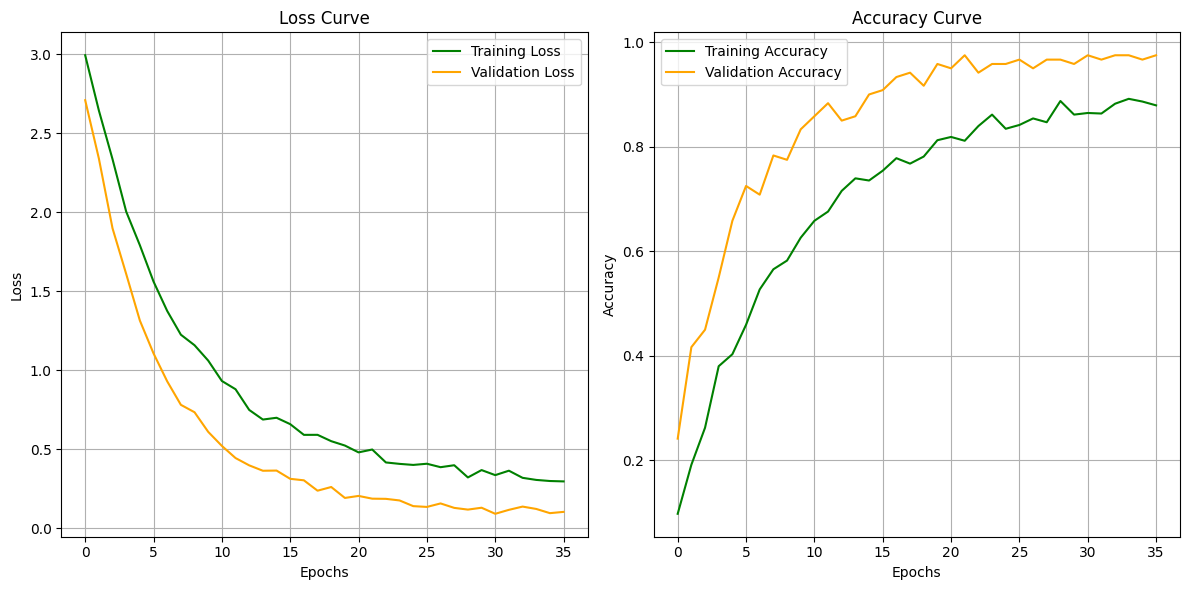

In [46]:
# Plot training loss and training accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

# Plotting validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

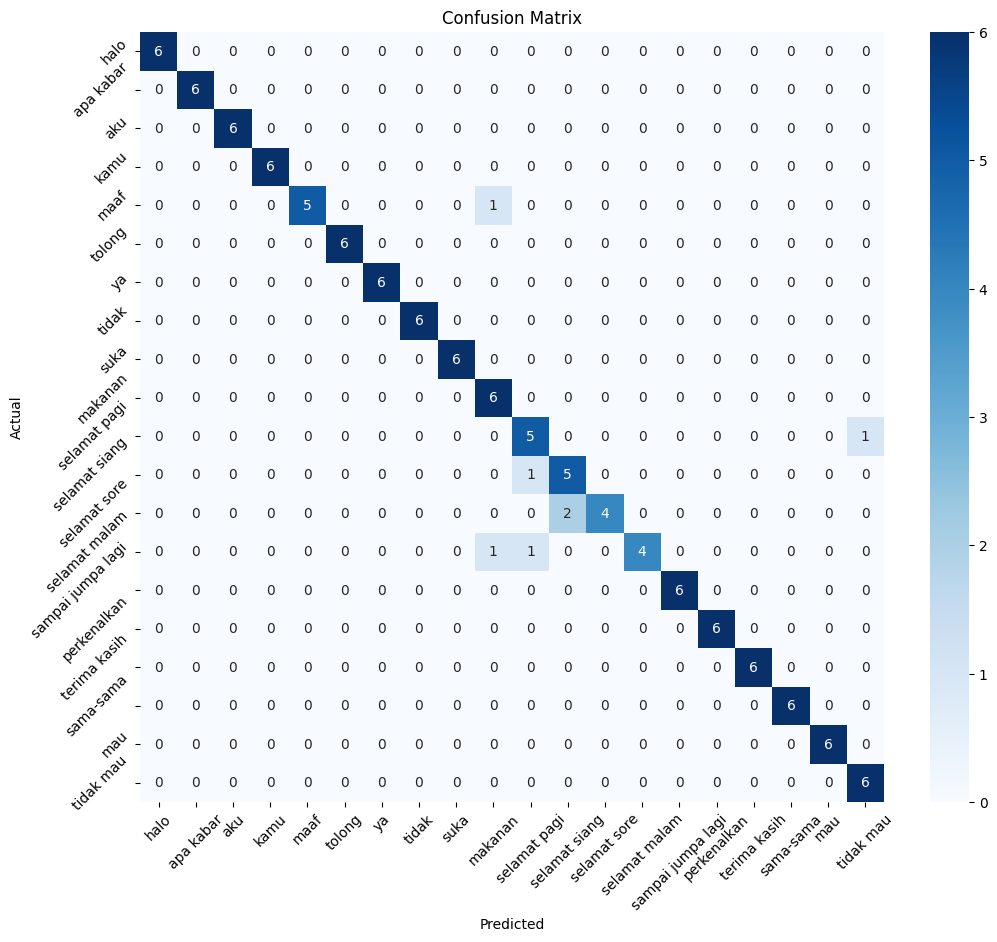


Precision: 0.9517857142857142
Recall: 0.9416666666666667
F1 Score: 0.9413886113886113

Classification Report:
                    precision    recall  f1-score   support

             halo       1.00      1.00      1.00         6
        apa kabar       1.00      1.00      1.00         6
              aku       1.00      1.00      1.00         6
             kamu       1.00      1.00      1.00         6
             maaf       1.00      0.83      0.91         6
           tolong       1.00      1.00      1.00         6
               ya       1.00      1.00      1.00         6
            tidak       1.00      1.00      1.00         6
             suka       1.00      1.00      1.00         6
          makanan       0.75      1.00      0.86         6
     selamat pagi       0.71      0.83      0.77         6
    selamat siang       0.71      0.83      0.77         6
     selamat sore       1.00      0.67      0.80         6
    selamat malam       1.00      0.67      0.80         6
sa

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Convert predictions & labels to integer class indices
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(res, axis=1).tolist()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels for the heatmap
class_labels = list(label_map.keys())  # Get sign language action labels

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Precision, Recall, F1-Score, and accuration
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

In [48]:
from collections import deque

SEQUENCE_LENGTH = 30  # number of frames per gesture
INPUT_SHAPE = (30, 258, 1)

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)
pose = mp_pose.Pose(static_image_mode=False)

# Data buffer
sequence = deque(maxlen=SEQUENCE_LENGTH)

# Start camera
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Get landmarks
    results_pose = pose.process(image)
    results_hands = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    landmarks = []

    # Pose landmarks (33 x 3)
    if results_pose.pose_landmarks:
        for lm in results_pose.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
    else:
        landmarks.extend([0] * 99)

    # Hand landmarks (21 x 3 per hand)
    for hand_landmarks in [results_hands.multi_hand_landmarks] if results_hands.multi_hand_landmarks else [None]:
        if hand_landmarks:
            for hand in hand_landmarks:
                for lm in hand.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
        else:
            landmarks.extend([0] * 63)  # 21 * 3

    # If 258-dim is collected, add to sequence
    if len(landmarks) == 258:
        sequence.append(landmarks)

    # Once we have 30 frames, predict
    if len(sequence) == SEQUENCE_LENGTH:
        input_data = np.array(sequence).reshape(1, *INPUT_SHAPE).astype('float32')
        prediction = model.predict(input_data)
        predicted_class = actions[np.argmax(prediction)]

        # Display result
        cv2.putText(image, f'Prediction: {predicted_class}', (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show frame
    cv2.imshow("Gesture Recognition", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release
cap.release()
cv2.destroyAllWindows()
hands.close()
pose.close()